<a href="https://colab.research.google.com/github/UdeS-PMF/gmq710_test/blob/develop/a2024_detect_object_in_map_with_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Récupérer le code de Yolo5

In [ ]:
# Clone the YOLOv5 GitHub repository
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 17059, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17059 (delta 18), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17059/17059), 15.68 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (11713/11713), done.


Importer les libs

In [ ]:
# Import necessary libraries
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set a seed for reproducibility
random.seed(108)

Créer la structure de mon dataset

In [ ]:
!mkdir yolov5/My_Dataset
!mkdir yolov5/My_Dataset/labels
!mkdir yolov5/My_Dataset/images

Utiliser l'outil *labelme* pour annoter les images (https://github.com/labelmeai/labelme?tab=readme-ov-file)

L'outil permet de créer un fichier json pour chaque image. Les images sont en format PNG. Par la suite on place les images dans le répertoire yolov5/My_Dataset/images et les fichiers json dans le répertoire yolov5/My_Dataset/labels

Fonction pour convertir les fichiers json en objet python

In [ ]:
# prompt: read a json file and display content

def extractInfoFromJson(jsonfilename):
  import json

  # Open the JSON file
  with open(jsonfilename, 'r') as file:
      # Load the JSON data into a Python dictionary
      data = json.load(file)


  info_dict = {}
  info_dict['bboxes'] = []

  # Print the contents of the dictionary
  filename = data['imagePath']
  width = data['imageWidth']
  height = data['imageHeight']

  info_dict['filename'] = filename
  info_dict['image_size'] = (width, height, 3)

  shapes = data['shapes']

  for shape in shapes:
    class_ = shape['label']
    xs = [x[0] for x in shape['points']]
    ys = [x[1] for x in shape['points']]

    info_dict['bboxes'].append(
        {'class': class_, 'xmin': min(xs), 'ymin': min(ys), 'xmax': max(xs), 'ymax': max(ys)}
    )
  return info_dict

infos = extractInfoFromJson('/content/yolov5/My_Dataset/labels/2024-11-22_16h07_52.json')
print(infos)

{'bboxes': [{'class': 'car', 'xmin': 77.66125290023201, 'ymin': 112.38863109048724, 'xmax': 105.27146171693737, 'ymax': 133.9663573085847}, {'class': 'car', 'xmin': 84.38979118329466, 'ymin': 100.55568445475639, 'xmax': 109.91183294663573, 'ymax': 122.59744779582367}], 'filename': '2024-11-22_16h07_52.png', 'image_size': (224, 209, 3)}


Objet python déclarant les objets à détecter

In [ ]:
class_name_to_id_mapping = {"car": 0}

Fonction permettant de convertir un fichier json en un fichier txt utilisé par YOLO

In [ ]:
# Function to convert annotation format to YOLOv5 format.
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("yolov5","My_Dataset", "labels", info_dict["filename"].replace("png", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

Conversion de tous les fichiers json

In [ ]:
# Get the JSON annotations
annotations = [os.path.join('yolov5','My_Dataset','labels', x) for x in os.listdir('yolov5/My_Dataset/labels') if x[-4:] == "json"]
annotations.sort()

# Convert and save the annotations in YOLOv5 format
for ann in tqdm(annotations):
    info_dict = extractInfoFromJson(ann)
    convert_to_yolov5(info_dict)

# Get the YOLOv5 format annotations
annotations = [os.path.join('yolov5','My_Dataset','labels', x) for x in os.listdir('yolov5/My_Dataset/labels') if x[-3:] == "txt"]
print(annotations)

100%|██████████| 15/15 [00:00<00:00, 3022.41it/s]

['yolov5/My_Dataset/labels/2024-11-22_16h09_20.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_27.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h09_41.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_11.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h09_28.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h07_59.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h07_52.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h09_33.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_49.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h11_10.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_44.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_32.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_21.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h09_12.txt', 'yolov5/My_Dataset/labels/2024-11-22_16h08_05.txt']


Teste une annotation au hasard (pour vérifier si cela correspond)

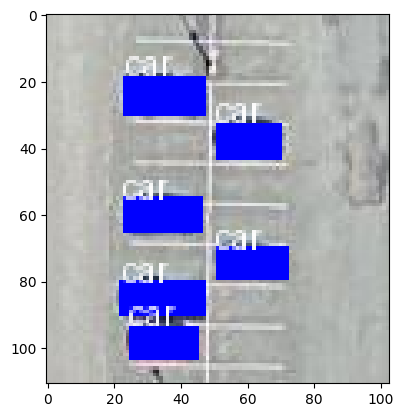

In [ ]:
# Set a seed for reproducibility
random.seed(0)

# Map class IDs to class names
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Function to plot bounding boxes on an image
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    # Transform annotations to image dimensions
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann

        plotted_image.rectangle(((x0,y0), (x1,y1)), fill=(0,0,255))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x] for x in annotation_list]


# Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "png")
if not os.path.exists(image_file):
    raise FileNotFoundError(f"Image file {image_file} does not exist.")
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('/content/yolov5/My_Dataset/images', x) for x in os.listdir('/content/yolov5/My_Dataset/images') if x[-3:] == "png"]
annotations = [os.path.join('yolov5','My_Dataset','labels', x) for x in os.listdir('yolov5/My_Dataset/labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()
print(f"Nombre d'images : {len(images)}")
print(f"Nombre d'annotations : {len(annotations)}")
# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state=1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=1)

Nombre d'images : 15
Nombre d'annotations : 15


Créer la structure pour l'apprentissage

In [ ]:
!mkdir /content/yolov5/My_Dataset/images/train
!mkdir /content/yolov5/My_Dataset/images/val
!mkdir /content/yolov5/My_Dataset/images/test
!mkdir /content/yolov5/My_Dataset/labels/train
!mkdir /content/yolov5/My_Dataset/labels/val
!mkdir /content/yolov5/My_Dataset/labels/test

Déplacer les fichiers selon leur implication (entraînement, validation et test)

In [ ]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/yolov5/My_Dataset/images/train')
move_files_to_folder(val_images, '/content/yolov5/My_Dataset/images/val/')
move_files_to_folder(test_images, '/content/yolov5/My_Dataset/images/test/')
move_files_to_folder(train_annotations, '/content/yolov5/My_Dataset/labels/train/')
move_files_to_folder(val_annotations, '/content/yolov5/My_Dataset/labels/val/')
move_files_to_folder(test_annotations, '/content/yolov5/My_Dataset/labels/test/')

Se mettre dans le répertoire de YOLO

In [ ]:
!cd /content/yolov5

Créer le fichier CONFIG

In [ ]:
# YAML content as raw text
yaml_content = """
train: My_Dataset/images/train/
val:  My_Dataset/images/val/
test: My_Dataset/images/test/

# number of classes
nc: 1

# class names
names: ["car"]
"""

# Path to the YAML file to create
yaml_file_path = '/content/yolov5/My_Dataset/data_conf.yaml'

# Write the content to the YAML file
with open(yaml_file_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

Définir les hyperparamètres

In [ ]:
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability

Déclencher l'entraînement avec un réseau pré-entraîné

In [ ]:
!python /content/yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.scratch-med.yaml --batch 32 --epochs 200 --data /content/yolov5/My_Dataset/data_conf.yaml --weights yolov5s.pt --workers 24 --name yolo_my_app_det


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 43.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-22 21:30:27.806996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 21:30:27.826929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 21:30:27.832718

Appliquer le réseau sur les images TEST (on peut récupérer les résultats d'analyse dans le répertoire /content/yolov5/runs/detect, attention à chaque exécution un nouveau sous-répertoire yolo_my_app_det va se créer)

In [ ]:
!python /content/yolov5/detect.py --source /content/yolov5/My_Dataset/images/test --weights /content/yolov5/runs/train/yolo_my_app_det/weights/best.pt --conf 0.25 --name yolo_my_app_det

detect: weights=['/content/yolov5/runs/train/yolo_my_app_det/weights/best.pt'], source=/content/yolov5/My_Dataset/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_my_app_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/2 /content/yolov5/My_Dataset/images/test/2024-11-22_16h08_11.png: 640x640 1 car, 11.5ms
image 2/2 /content/yolov5/My_Dataset/images/test/2024-11-22_16h08_32.png: 544x640 1 car, 28.5ms
Speed

Exemple d'un résultat

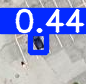

In [ ]:
# prompt: display an image png

from IPython.display import Image

Image("/content/yolov5/runs/detect/yolo_my_app_det/2024-11-22_16h08_11.png")


In [ ]:
!python /content/yolov5/detect.py --source /content/yolov5/My_Dataset/my_test_image --weights /content/yolov5/runs/train/yolo_my_app_det/weights/best.pt --conf 0.75 --name yolo_my_app_det2

detect: weights=['/content/yolov5/runs/train/yolo_my_app_det/weights/best.pt'], source=/content/yolov5/My_Dataset/my_test_image, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.75, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_my_app_det2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/My_Dataset/my_test_image/2024-11-22_16h32_11.png: 416x640 2 cars, 30.3ms
Speed: 0.6ms pre-process, 30.3ms inference, 532.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/yolo_my_a

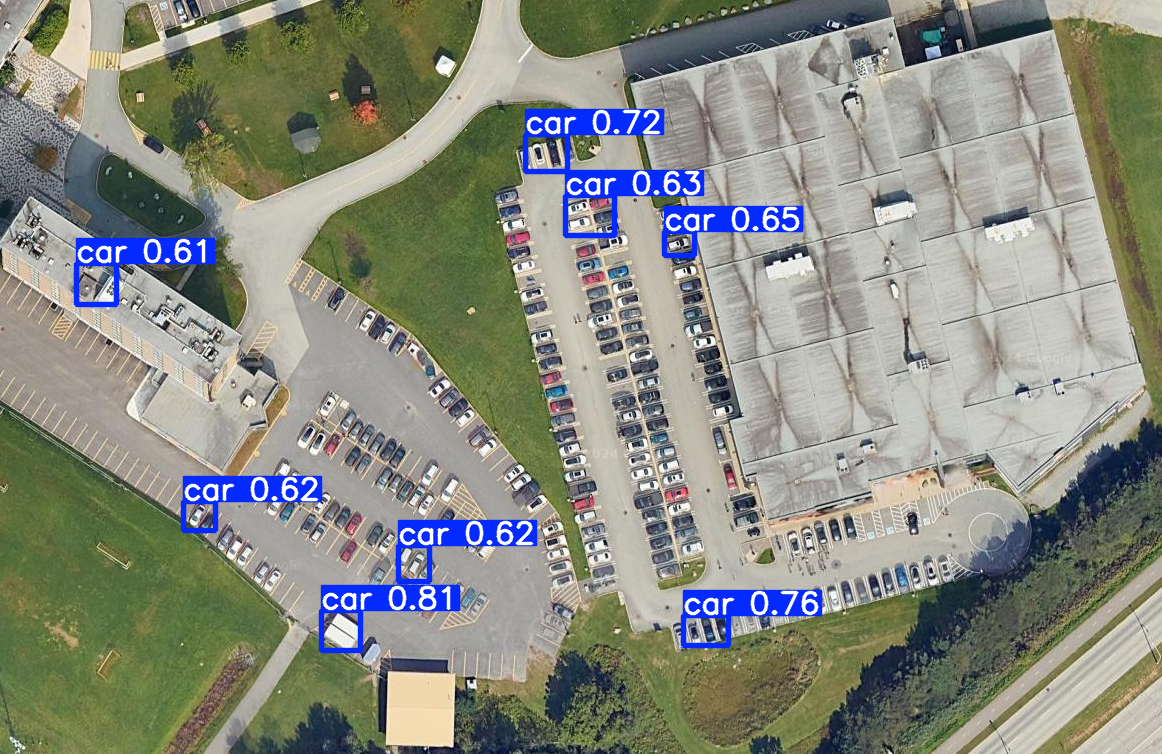

In [ ]:
# prompt: display an image png

from IPython.display import Image

Image("/content/yolov5/runs/detect/yolo_my_app_det22/2024-11-22_16h32_11.png")